# Activation Functions

```{admonition} Attribution
The following notebook is a fork of [Tutorial 3](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html) of the [Deep Learning Course](https://uvadlc.github.io/lectures-nov2020.html#) at the University of Amsterdam. The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.
```

In this tutorial, we will take a closer look at popular activation functions and investigate their effect on optimization properties in neural networks.
Activation functions are a crucial part of deep learning models as they add the non-linearity to neural networks.
There is a great variety of activation functions in the literature, and some are more beneficial than others.
The goal of this tutorial is to show the importance of choosing a good activation function (and how to do so), and what problems might occur if we don't.

Before we start, we import our standard libraries and set up basic functions:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import pathlib
import json
import math
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

We will define a function to set a seed on all libraries we might interact with in this tutorial (here `numpy` and `torch`). This allows us to make our training reproducible. However, note that in contrast to the CPU, the same seed on different GPU architectures can give different results. All models here have been trained on a NVIDIA Tesla P100, which is provided free in a Kaggle kernel.

In [2]:
def set_seed(seed):
    """Function for setting the seed."""
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Separate seed for GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        
        
# Set random seed
set_seed(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = True # https://stackoverflow.com/a/58965640

# Set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Additionally, the following cell defines two paths: `DATASET_PATH` and `CHECKPOINT_PATH`. The dataset path is the directory where we will download datasets used in the notebooks. It is recommended to store all datasets from PyTorch in one joined directory to prevent duplicate downloads. The checkpoint path is the directory where we will store trained model weights and additional files.

In [3]:
# Path to datasets, e.g. MNIST, and path to pretrained models
DATASET_PATH = pathlib.Path("/kaggle/working/data") 
CHECKPOINT_PATH = pathlib.Path("/kaggle/working/saved_models/tutorial3")

# Create directories; exists -> skip, no parent -> create
DATASET_PATH.mkdir(exist_ok=True, parents=True)
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

We also define two utility functions for constructing the appropriate file paths.

In [4]:
def _get_config_file(model_path: pathlib.Path, model_name: str) -> pathlib.Path:
    return model_path / (model_name + ".config")

def _get_model_file(model_path: pathlib.Path, model_name: str) -> pathlib.Path: 
    return model_path / (model_name + ".tar")

## Common activation functions

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the `torch.nn` package. However, we'll write our own functions here for a better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit:

In [5]:
class ActivationFunction(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network. We will use the `config` dictionary to store adjustable parameters for some activation functions.

Next, we implement two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh. 
Both the sigmoid and tanh activation can be also found as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or as modules (`nn.Sigmoid`, `nn.Tanh`). 
Here, we implement them by hand:

In [6]:
##############################

class Sigmoid(ActivationFunction):
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################
    
class Tanh(ActivationFunction):
    
    def forward(self, x):
        exp_x, exp_neg_x = torch.exp(x), torch.exp(-x)
        return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)
    
##############################

Another popular activation function that has allowed the training of deeper networks, is the **Rectified Linear Unit (ReLU)**. 
Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values.
Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: **LeakyReLU**, **ELU**, and **Swish**. Modifications on the ReLU improves on zero-centering of outputs, vanishing gradients on the negative axis, and smoothness of gradients around zero.

```{margin}
If interested, a more detailed discussion of the benefits of Swish can be found in this paper https://arxiv.org/abs/1710.05941.
```

LeakyReLU replaces the zero settings in the negative part with a smaller slope to allow gradients to flow also in this part of the input.
Similarly, ELU replaces the negative part with an exponential decay.
The third, most recently proposed activation function is Swish, which is actually the result of a large experiment with the purpose of finding the "optimal" activation function. 
Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. contains a change of sign in the gradient). Moreover, Swish is the only activation in our list which has maximum gradient greater than one.
This has been shown to prevent dead neurons as in standard ReLU activation, especially for deep networks. Let's implement the four activation functions below:

In [7]:
##############################

class ReLU(ActivationFunction):
    
    def forward(self, x):
        return x * (x > 0).float()

##############################
    
class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################
    
class ELU(ActivationFunction):
    
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)

##############################
    
class Swish(ActivationFunction):
    
    def forward(self, x):
        return x * torch.sigmoid(x)
    
##############################

For later usage, we summarize all our activation functions in a dictionary mapping the name to the class object. In case you implement a new activation function by yourself, add it here to include it in future comparisons as well:

In [8]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
}

### Visualizing activation functions

To get an idea of what each activation function actually does, we will visualize them in the following. 
Next to the actual activation value, the gradient of the function is an important aspect as it is crucial for optimizing the neural network. 
PyTorch allows us to compute the gradients simply by calling the `backward` function:

In [9]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.
    
    Inputs:
        act_fn: An instance of `ActivationFunction` with an implemented forward pass.
        x: 1D input tensor. 
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_(True)
    out = act_fn(x)
    out.sum().backward() # Trick: 𝜕(y1 + y2) / 𝜕x1 = 𝜕y1 / 𝜕x1 => stored at x1. 
    
    return x.grad

Now we can visualize all our activation functions including their gradients:

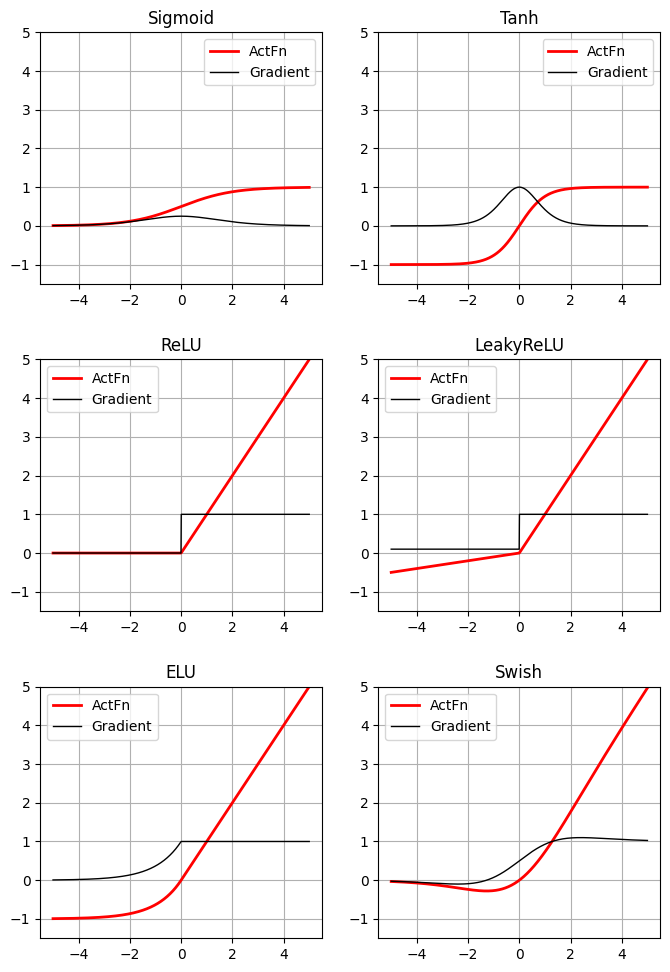

In [10]:
def visualize_act_fn(act_fn, ax, x):
    
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    
    # Plotting
    ax.plot(x, y, linewidth=2, color='red', label="ActFn")
    ax.plot(x, y_grads, linewidth=1, color='black', label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.grid()
    ax.set_ylim(-1.5, x.max())

# Initialize activations in a list
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]

# Plotting
x = torch.linspace(-5, 5, 1000)
rows = math.ceil(len(act_fns) / 2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4), dpi=100)
for i, act_fn in enumerate(act_fns):
    visualize_act_fn(act_fn, ax[divmod(i, 2)], x) # divmod(m, n) = m // n, m % n

fig.subplots_adjust(hspace=0.3)
plt.show()

## Analysing the effect of activation functions

After implementing and visualizing the activation functions, we are aiming to gain insights into their effect. 
We do this by using a simple neural network trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) and examine various aspects of the model, including the performance and gradient flow.

### Setup

Firstly, let's set up a neural network. The chosen network views the images as 1D tensors and pushes them through a sequence of linear layers and a specified activation function. Feel free to experiment with other network architectures.

In [11]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()
        
        # Create the network based on the specified hidden sizes
        # Iteratively add linear layer, followed by activation modules
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for i in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[i-1], layer_sizes[i]), act_fn]
            
        # Add output layer. Combine modules via nn.Sequential
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)
        
        # Store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {
            "act_fn": act_fn.config, 
            "input_size": input_size, 
            "num_classes": num_classes, 
            "hidden_sizes": hidden_sizes
        }
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector, i.e. B = x.size(0)
        out = self.layers(x)
        return out    

We also set up the dataset we want to train it on, namely [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). FashionMNIST is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. To load this dataset, we will make use of yet another PyTorch package, namely `torchvision` ([documentation](https://pytorch.org/docs/stable/torchvision/index.html)). The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We will use the package for many of the notebooks in this course to simplify our dataset handling. 

In [12]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# Define a set of data loaders that we can use for various purposes later.
# For actual model training, we will use different data loaders with lower batch sizes.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /kaggle/working/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /kaggle/working/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /kaggle/working/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /kaggle/working/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's visualize a few images to get an impression of the data.

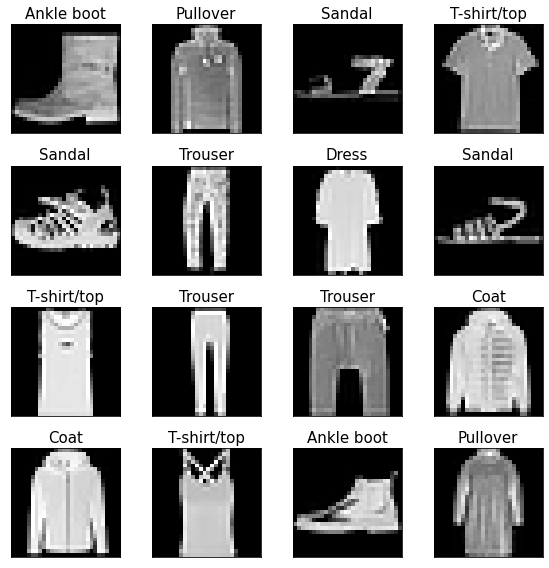

In [13]:
exmp_imgs = [train_set[i] for i in range(16)]
class_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

fig = plt.figure(figsize=(8, 8))
for i, (img, label) in enumerate(exmp_imgs):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.cpu().numpy()[0, :, :], cmap="gray")
    ax.set_title(class_map[label], size=15)
    
plt.tight_layout()
plt.show()

### Visualizing the gradient flow after initialization

As mentioned previously, one important aspect of activation functions is how they propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is (in expectation) considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode. 

To get a feeling of how every activation function influences the gradients, we can look at a freshly initialized network and measure the gradients for each parameter for a batch of 256 images.

In [14]:
def visualize_gradients(net, color="C0"):
    """
    Inputs
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    
    net.eval()
    
    # Get one batch (size=256) of images
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass the batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    # Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0

    for key in reversed(sorted(grads.keys())):
        key_ax = ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_xlabel("Grad magnitude")
        key_ax.set_title(key)
        fig_index += 1
        
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close() 

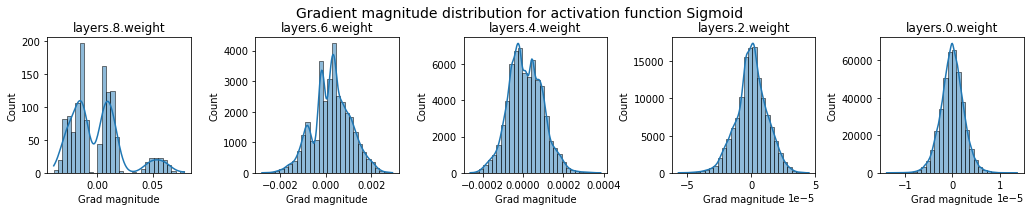

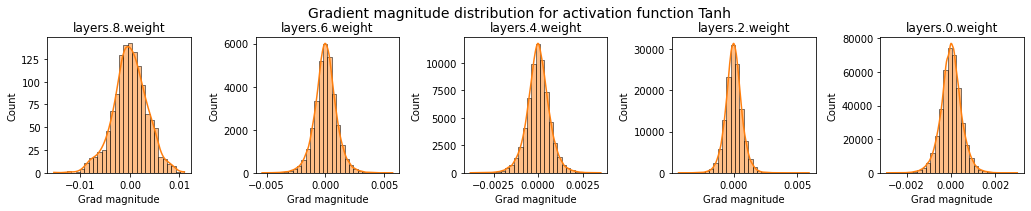

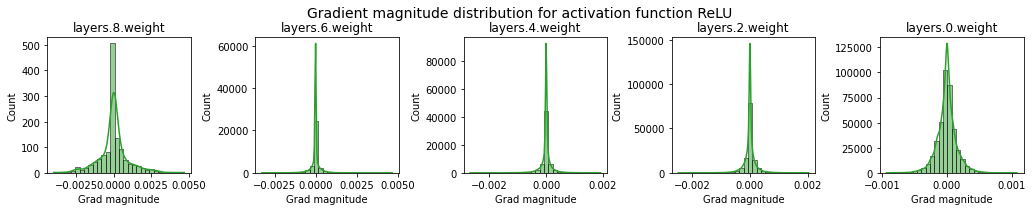

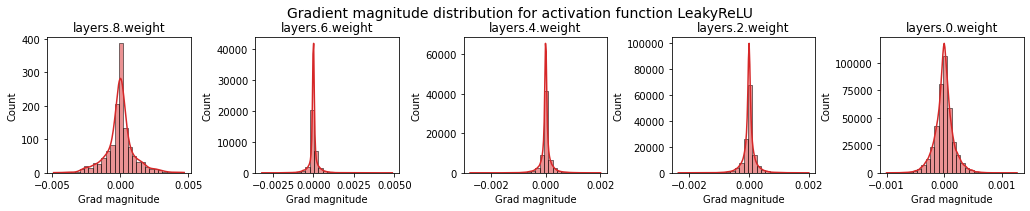

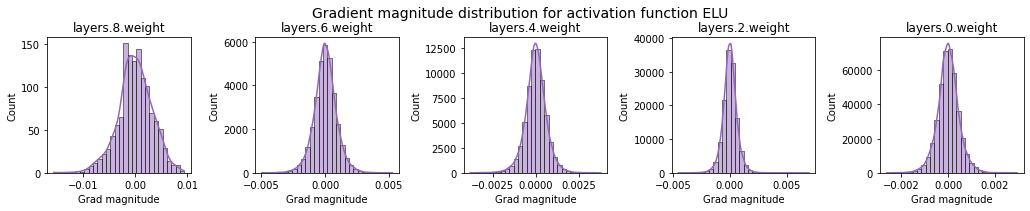

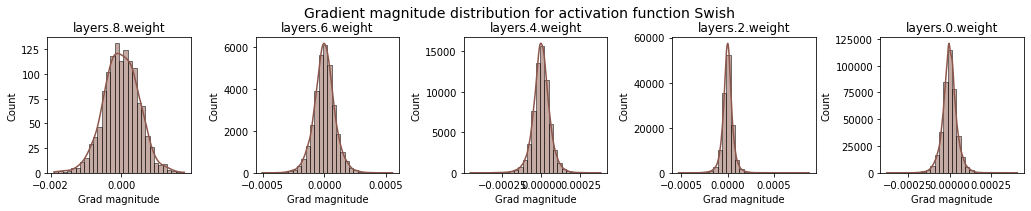

In [15]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')

# Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup.
All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons (we will take a closer look at this later on).

Note that additionally to the activation, the **initialization** of the weight parameters can be crucial. By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialization for linear layers optimized for ReLU activations. In [Optimization and Initialization](https://particle1331.github.io/machine-learning/notebooks/pytorch-optim-init.html), we will take a closer look at initialization, but assume for now that the Kaiming initialization works for all activation functions reasonably well.

### Saving and loading a model

Before proceeding to model training, we define and test utility functions for saving and loading PyTorch models. The hyperparameters are stored in a configuration file (simple JSON file), while values of parameters that the network has learned are stored in a tar file.


In [16]:
from typing import Optional

def load_model(
    model_path: pathlib.Path, 
    model_name: str, 
    net: Optional[nn.Module] = None) -> nn.Module:
    """
    Loads a saved model from disk.
    
    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    
    # Get pathlib paths of model and config files; check if existing
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    
    error_msg = lambda fn: f"Could not find the file \"{fn}\"."
    assert config_file.is_file(), error_msg(config_file)
    assert model_file.is_file(), error_msg(model_file)
    
    # If no network passed, init. network with architecture from config
    if net is None:
        with open(config_file, "r") as f:
            config_dict = json.load(f)
        
        # Recall structure of config file in BaseNetwork
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    
    # Load weights to network
    state_dict = torch.load(model_file, map_location=device)
    net.load_state_dict(state_dict)
    
    return net
    
    
def save_model(
    model: nn.Module, 
    model_path: pathlib.Path,
    model_name: str) -> None:
    """
    Given a model, we save the state_dict and hyperparameters.
    
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    
    config_dict = model.config
    model_path.mkdir(exist_ok=True, parents=True)
    
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
        
    torch.save(model.state_dict(), model_file)

Testing `save_model`:

In [17]:
model = BaseNetwork(Sigmoid(), input_size=1, num_classes=1, hidden_sizes=[1, 1, 1])
save_model(model, model_path=CHECKPOINT_PATH, model_name="test_save_model")

Checking artifacts of `save_model`:

In [18]:
config_file = _get_config_file(CHECKPOINT_PATH, 'test_save_model')
with open(config_file, "r") as f:
    config_dict = json.load(f)

config_dict

{'act_fn': {'name': 'Sigmoid'},
 'input_size': 1,
 'num_classes': 1,
 'hidden_sizes': [1, 1, 1]}

Incidentally, we can test `load_model`:

In [19]:
model_file = _get_model_file(CHECKPOINT_PATH, 'test_save_model')
torch.load(model_file, map_location=device)

OrderedDict([('layers.0.weight', tensor([[-0.8584]], device='cuda:0')),
             ('layers.0.bias', tensor([-0.2528], device='cuda:0')),
             ('layers.2.weight', tensor([[-0.0063]], device='cuda:0')),
             ('layers.2.bias', tensor([-0.3326], device='cuda:0')),
             ('layers.4.weight', tensor([[0.9424]], device='cuda:0')),
             ('layers.4.bias', tensor([0.7875], device='cuda:0')),
             ('layers.6.weight', tensor([[-0.5816]], device='cuda:0')),
             ('layers.6.bias', tensor([0.5567], device='cuda:0'))])

### Training a model

Next, we want to train our model with different activation functions on FashionMNIST and compare the gained performance. All in all, our final goal is to achieve the best possible performance on a dataset of our choice. 
Therefore, we write a training loop in the next cell including a validation after every epoch and a final test on the best model:

In [20]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    
    file_exists = _get_model_file(CHECKPOINT_PATH, model_name).is_file()
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
        loss_module = nn.CrossEntropyLoss() 
        train_loader_local = data.DataLoader(train_set, 
                                             batch_size=batch_size, 
                                             shuffle=True, # shuffle at every epoch
                                             drop_last=True, 
                                             pin_memory=True) 

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) 
                optimizer.zero_grad()
                
                # Backward pass
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                
                # Record statistics during training
                true_preds += (preds.argmax(dim=1) == labels).sum()
                count += labels.shape[0]
            
            train_acc = true_preds / count
            
            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            
            elif best_val_epoch + patience <= epoch:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    # Load best weights and evaluate on test set
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(47, "=")+"\n")
    return test_acc
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

We train one model for each activation function. We recommend using the pretrained models to save time if you are running this notebook on CPU.

Training BaseNetwork with sigmoid activation...


[Epoch  1] Training accuracy: 09.96%, Validation accuracy: 10.74%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 09.91%, Validation accuracy: 09.99%


[Epoch  3] Training accuracy: 10.10%, Validation accuracy: 09.85%


[Epoch  4] Training accuracy: 10.02%, Validation accuracy: 10.74%


[Epoch  5] Training accuracy: 10.16%, Validation accuracy: 10.32%


[Epoch  6] Training accuracy: 10.12%, Validation accuracy: 10.74%


[Epoch  7] Training accuracy: 10.03%, Validation accuracy: 10.27%


[Epoch  8] Training accuracy: 10.12%, Validation accuracy: 09.45%
Early stopping due to no improvement over the last 7 epochs


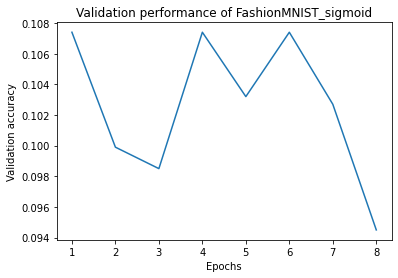

============ Test accuracy: 10.00% ============

Training BaseNetwork with tanh activation...


[Epoch  1] Training accuracy: 66.47%, Validation accuracy: 77.99%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 81.39%, Validation accuracy: 82.04%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 84.07%, Validation accuracy: 84.40%
	   (New best performance, saving model...)


[Epoch  4] Training accuracy: 85.21%, Validation accuracy: 84.46%
	   (New best performance, saving model...)


[Epoch  5] Training accuracy: 85.77%, Validation accuracy: 84.34%


[Epoch  6] Training accuracy: 86.37%, Validation accuracy: 86.53%
	   (New best performance, saving model...)


[Epoch  7] Training accuracy: 86.80%, Validation accuracy: 86.52%


[Epoch  8] Training accuracy: 87.32%, Validation accuracy: 86.19%


[Epoch  9] Training accuracy: 87.34%, Validation accuracy: 85.36%


[Epoch 10] Training accuracy: 87.87%, Validation accuracy: 86.72%
	   (New best performance, saving model...)


[Epoch 11] Training accuracy: 88.45%, Validation accuracy: 86.89%
	   (New best performance, saving model...)


[Epoch 12] Training accuracy: 88.41%, Validation accuracy: 87.48%
	   (New best performance, saving model...)


[Epoch 13] Training accuracy: 88.75%, Validation accuracy: 87.52%
	   (New best performance, saving model...)


[Epoch 14] Training accuracy: 88.93%, Validation accuracy: 87.35%


[Epoch 15] Training accuracy: 89.28%, Validation accuracy: 87.18%


[Epoch 16] Training accuracy: 89.53%, Validation accuracy: 88.12%
	   (New best performance, saving model...)


[Epoch 17] Training accuracy: 89.85%, Validation accuracy: 87.74%


[Epoch 18] Training accuracy: 89.82%, Validation accuracy: 88.19%
	   (New best performance, saving model...)


[Epoch 19] Training accuracy: 90.28%, Validation accuracy: 87.53%


[Epoch 20] Training accuracy: 90.25%, Validation accuracy: 88.48%
	   (New best performance, saving model...)


[Epoch 21] Training accuracy: 90.51%, Validation accuracy: 88.46%


[Epoch 22] Training accuracy: 90.77%, Validation accuracy: 88.24%


[Epoch 23] Training accuracy: 91.10%, Validation accuracy: 88.08%


[Epoch 24] Training accuracy: 90.91%, Validation accuracy: 88.36%


[Epoch 25] Training accuracy: 91.09%, Validation accuracy: 88.67%
	   (New best performance, saving model...)


[Epoch 26] Training accuracy: 91.42%, Validation accuracy: 88.22%


[Epoch 27] Training accuracy: 91.58%, Validation accuracy: 89.14%
	   (New best performance, saving model...)


[Epoch 28] Training accuracy: 91.86%, Validation accuracy: 89.12%


[Epoch 29] Training accuracy: 91.96%, Validation accuracy: 88.31%


[Epoch 30] Training accuracy: 92.02%, Validation accuracy: 88.45%


[Epoch 31] Training accuracy: 92.04%, Validation accuracy: 88.28%


[Epoch 32] Training accuracy: 92.44%, Validation accuracy: 89.13%


[Epoch 33] Training accuracy: 92.20%, Validation accuracy: 88.43%


[Epoch 34] Training accuracy: 92.42%, Validation accuracy: 89.30%
	   (New best performance, saving model...)


[Epoch 35] Training accuracy: 92.59%, Validation accuracy: 89.34%
	   (New best performance, saving model...)


[Epoch 36] Training accuracy: 93.05%, Validation accuracy: 88.91%


[Epoch 37] Training accuracy: 92.90%, Validation accuracy: 89.28%


[Epoch 38] Training accuracy: 93.19%, Validation accuracy: 89.19%


[Epoch 39] Training accuracy: 93.45%, Validation accuracy: 88.36%


[Epoch 40] Training accuracy: 93.52%, Validation accuracy: 89.18%


[Epoch 41] Training accuracy: 93.53%, Validation accuracy: 89.03%


[Epoch 42] Training accuracy: 93.79%, Validation accuracy: 89.22%
Early stopping due to no improvement over the last 7 epochs


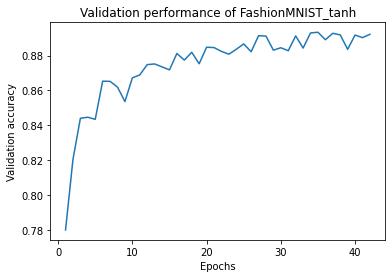

============ Test accuracy: 88.09% ============

Training BaseNetwork with relu activation...


[Epoch  1] Training accuracy: 50.08%, Validation accuracy: 73.23%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 78.91%, Validation accuracy: 80.88%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 83.15%, Validation accuracy: 84.08%
	   (New best performance, saving model...)


[Epoch  4] Training accuracy: 84.89%, Validation accuracy: 84.83%
	   (New best performance, saving model...)


[Epoch  5] Training accuracy: 85.75%, Validation accuracy: 85.09%
	   (New best performance, saving model...)


[Epoch  6] Training accuracy: 86.79%, Validation accuracy: 86.62%
	   (New best performance, saving model...)


[Epoch  7] Training accuracy: 87.51%, Validation accuracy: 87.29%
	   (New best performance, saving model...)


[Epoch  8] Training accuracy: 88.30%, Validation accuracy: 87.39%
	   (New best performance, saving model...)


[Epoch  9] Training accuracy: 88.49%, Validation accuracy: 86.02%


[Epoch 10] Training accuracy: 89.10%, Validation accuracy: 87.71%
	   (New best performance, saving model...)


[Epoch 11] Training accuracy: 89.51%, Validation accuracy: 87.91%
	   (New best performance, saving model...)


[Epoch 12] Training accuracy: 89.86%, Validation accuracy: 87.19%


[Epoch 13] Training accuracy: 90.18%, Validation accuracy: 88.97%
	   (New best performance, saving model...)


[Epoch 14] Training accuracy: 90.57%, Validation accuracy: 87.64%


[Epoch 15] Training accuracy: 90.87%, Validation accuracy: 87.96%


[Epoch 16] Training accuracy: 91.39%, Validation accuracy: 87.94%


[Epoch 17] Training accuracy: 91.36%, Validation accuracy: 89.40%
	   (New best performance, saving model...)


[Epoch 18] Training accuracy: 91.55%, Validation accuracy: 88.77%


[Epoch 19] Training accuracy: 92.10%, Validation accuracy: 88.86%


[Epoch 20] Training accuracy: 92.17%, Validation accuracy: 88.98%


[Epoch 21] Training accuracy: 92.71%, Validation accuracy: 88.90%


[Epoch 22] Training accuracy: 92.81%, Validation accuracy: 89.30%


[Epoch 23] Training accuracy: 93.25%, Validation accuracy: 89.35%


[Epoch 24] Training accuracy: 93.31%, Validation accuracy: 89.24%
Early stopping due to no improvement over the last 7 epochs


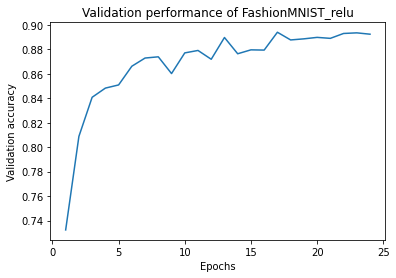

============ Test accuracy: 88.34% ============

Training BaseNetwork with leakyrelu activation...


[Epoch  1] Training accuracy: 51.00%, Validation accuracy: 74.58%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 79.20%, Validation accuracy: 80.55%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 83.03%, Validation accuracy: 83.96%
	   (New best performance, saving model...)


[Epoch  4] Training accuracy: 84.78%, Validation accuracy: 84.54%
	   (New best performance, saving model...)


[Epoch  5] Training accuracy: 85.58%, Validation accuracy: 85.18%
	   (New best performance, saving model...)


[Epoch  6] Training accuracy: 86.63%, Validation accuracy: 86.46%
	   (New best performance, saving model...)


[Epoch  7] Training accuracy: 87.22%, Validation accuracy: 87.14%
	   (New best performance, saving model...)


[Epoch  8] Training accuracy: 87.90%, Validation accuracy: 86.94%


[Epoch  9] Training accuracy: 88.27%, Validation accuracy: 86.50%


[Epoch 10] Training accuracy: 88.64%, Validation accuracy: 87.21%
	   (New best performance, saving model...)


[Epoch 11] Training accuracy: 89.07%, Validation accuracy: 87.70%
	   (New best performance, saving model...)


[Epoch 12] Training accuracy: 89.36%, Validation accuracy: 87.05%


[Epoch 13] Training accuracy: 89.53%, Validation accuracy: 88.66%
	   (New best performance, saving model...)


[Epoch 14] Training accuracy: 90.05%, Validation accuracy: 87.51%


[Epoch 15] Training accuracy: 90.39%, Validation accuracy: 87.31%


[Epoch 16] Training accuracy: 90.78%, Validation accuracy: 87.88%


[Epoch 17] Training accuracy: 90.74%, Validation accuracy: 89.09%
	   (New best performance, saving model...)


[Epoch 18] Training accuracy: 91.00%, Validation accuracy: 88.56%


[Epoch 19] Training accuracy: 91.62%, Validation accuracy: 88.40%


[Epoch 20] Training accuracy: 91.56%, Validation accuracy: 88.63%


[Epoch 21] Training accuracy: 92.01%, Validation accuracy: 88.72%


[Epoch 22] Training accuracy: 92.16%, Validation accuracy: 89.20%
	   (New best performance, saving model...)


[Epoch 23] Training accuracy: 92.36%, Validation accuracy: 89.09%


[Epoch 24] Training accuracy: 92.68%, Validation accuracy: 89.03%


[Epoch 25] Training accuracy: 92.90%, Validation accuracy: 88.65%


[Epoch 26] Training accuracy: 93.12%, Validation accuracy: 89.08%


[Epoch 27] Training accuracy: 93.01%, Validation accuracy: 89.03%


[Epoch 28] Training accuracy: 93.41%, Validation accuracy: 88.66%


[Epoch 29] Training accuracy: 93.63%, Validation accuracy: 89.34%
	   (New best performance, saving model...)


[Epoch 30] Training accuracy: 93.55%, Validation accuracy: 88.79%


[Epoch 31] Training accuracy: 93.83%, Validation accuracy: 89.57%
	   (New best performance, saving model...)


[Epoch 32] Training accuracy: 94.27%, Validation accuracy: 89.09%


[Epoch 33] Training accuracy: 94.02%, Validation accuracy: 88.84%


[Epoch 34] Training accuracy: 94.41%, Validation accuracy: 88.93%


[Epoch 35] Training accuracy: 94.69%, Validation accuracy: 89.14%


[Epoch 36] Training accuracy: 94.94%, Validation accuracy: 89.70%
	   (New best performance, saving model...)


[Epoch 37] Training accuracy: 94.89%, Validation accuracy: 88.85%


[Epoch 38] Training accuracy: 95.05%, Validation accuracy: 88.59%


[Epoch 39] Training accuracy: 95.19%, Validation accuracy: 89.02%


[Epoch 40] Training accuracy: 95.52%, Validation accuracy: 89.26%


[Epoch 41] Training accuracy: 95.51%, Validation accuracy: 88.86%


[Epoch 42] Training accuracy: 95.91%, Validation accuracy: 89.45%


[Epoch 43] Training accuracy: 95.90%, Validation accuracy: 87.54%
Early stopping due to no improvement over the last 7 epochs


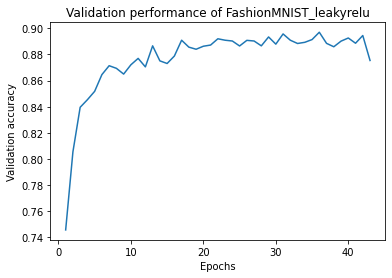

============ Test accuracy: 88.95% ============

Training BaseNetwork with elu activation...


[Epoch  1] Training accuracy: 66.24%, Validation accuracy: 78.28%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 81.45%, Validation accuracy: 82.09%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 83.84%, Validation accuracy: 84.07%
	   (New best performance, saving model...)


[Epoch  4] Training accuracy: 84.99%, Validation accuracy: 84.69%
	   (New best performance, saving model...)


[Epoch  5] Training accuracy: 85.50%, Validation accuracy: 85.15%
	   (New best performance, saving model...)


[Epoch  6] Training accuracy: 86.06%, Validation accuracy: 86.09%
	   (New best performance, saving model...)


[Epoch  7] Training accuracy: 86.57%, Validation accuracy: 86.21%
	   (New best performance, saving model...)


[Epoch  8] Training accuracy: 86.92%, Validation accuracy: 85.84%


[Epoch  9] Training accuracy: 87.06%, Validation accuracy: 84.44%


[Epoch 10] Training accuracy: 87.45%, Validation accuracy: 87.27%
	   (New best performance, saving model...)


[Epoch 11] Training accuracy: 87.91%, Validation accuracy: 86.08%


[Epoch 12] Training accuracy: 88.14%, Validation accuracy: 87.03%


[Epoch 13] Training accuracy: 88.36%, Validation accuracy: 87.16%


[Epoch 14] Training accuracy: 88.58%, Validation accuracy: 87.36%
	   (New best performance, saving model...)


[Epoch 15] Training accuracy: 88.76%, Validation accuracy: 86.78%


[Epoch 16] Training accuracy: 88.98%, Validation accuracy: 87.89%
	   (New best performance, saving model...)


[Epoch 17] Training accuracy: 89.26%, Validation accuracy: 87.67%


[Epoch 18] Training accuracy: 89.40%, Validation accuracy: 88.04%
	   (New best performance, saving model...)


[Epoch 19] Training accuracy: 89.58%, Validation accuracy: 87.49%


[Epoch 20] Training accuracy: 89.76%, Validation accuracy: 87.94%


[Epoch 21] Training accuracy: 90.03%, Validation accuracy: 88.06%
	   (New best performance, saving model...)


[Epoch 22] Training accuracy: 90.22%, Validation accuracy: 88.22%
	   (New best performance, saving model...)


[Epoch 23] Training accuracy: 90.47%, Validation accuracy: 87.89%


[Epoch 24] Training accuracy: 90.40%, Validation accuracy: 88.58%
	   (New best performance, saving model...)


[Epoch 25] Training accuracy: 90.61%, Validation accuracy: 88.13%


[Epoch 26] Training accuracy: 90.79%, Validation accuracy: 87.99%


[Epoch 27] Training accuracy: 90.75%, Validation accuracy: 88.35%


[Epoch 28] Training accuracy: 91.09%, Validation accuracy: 88.64%
	   (New best performance, saving model...)


[Epoch 29] Training accuracy: 91.05%, Validation accuracy: 88.60%


[Epoch 30] Training accuracy: 91.34%, Validation accuracy: 88.84%
	   (New best performance, saving model...)


[Epoch 31] Training accuracy: 91.42%, Validation accuracy: 88.75%


[Epoch 32] Training accuracy: 91.57%, Validation accuracy: 88.81%


[Epoch 33] Training accuracy: 91.55%, Validation accuracy: 88.70%


[Epoch 34] Training accuracy: 91.63%, Validation accuracy: 89.01%
	   (New best performance, saving model...)


[Epoch 35] Training accuracy: 91.85%, Validation accuracy: 88.77%


[Epoch 36] Training accuracy: 92.03%, Validation accuracy: 88.87%


[Epoch 37] Training accuracy: 92.07%, Validation accuracy: 88.56%


[Epoch 38] Training accuracy: 92.24%, Validation accuracy: 88.85%


[Epoch 39] Training accuracy: 92.30%, Validation accuracy: 88.16%


[Epoch 40] Training accuracy: 92.38%, Validation accuracy: 88.58%


[Epoch 41] Training accuracy: 92.54%, Validation accuracy: 88.55%
Early stopping due to no improvement over the last 7 epochs


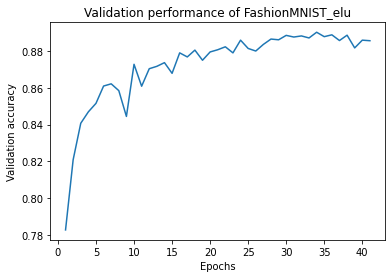

============ Test accuracy: 87.77% ============

Training BaseNetwork with swish activation...


[Epoch  1] Training accuracy: 28.05%, Validation accuracy: 30.44%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 65.12%, Validation accuracy: 74.24%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 79.37%, Validation accuracy: 81.53%
	   (New best performance, saving model...)


[Epoch  4] Training accuracy: 82.46%, Validation accuracy: 83.27%
	   (New best performance, saving model...)


[Epoch  5] Training accuracy: 83.86%, Validation accuracy: 81.90%


[Epoch  6] Training accuracy: 84.84%, Validation accuracy: 84.82%
	   (New best performance, saving model...)


[Epoch  7] Training accuracy: 85.55%, Validation accuracy: 85.16%
	   (New best performance, saving model...)


[Epoch  8] Training accuracy: 86.06%, Validation accuracy: 85.03%


[Epoch  9] Training accuracy: 86.22%, Validation accuracy: 84.25%


[Epoch 10] Training accuracy: 86.66%, Validation accuracy: 86.16%
	   (New best performance, saving model...)


[Epoch 11] Training accuracy: 87.08%, Validation accuracy: 85.88%


[Epoch 12] Training accuracy: 87.37%, Validation accuracy: 86.85%
	   (New best performance, saving model...)


[Epoch 13] Training accuracy: 87.60%, Validation accuracy: 86.74%


[Epoch 14] Training accuracy: 87.73%, Validation accuracy: 87.41%
	   (New best performance, saving model...)


[Epoch 15] Training accuracy: 88.17%, Validation accuracy: 85.57%


[Epoch 16] Training accuracy: 88.37%, Validation accuracy: 87.51%
	   (New best performance, saving model...)


[Epoch 17] Training accuracy: 88.76%, Validation accuracy: 87.13%


[Epoch 18] Training accuracy: 88.91%, Validation accuracy: 87.75%
	   (New best performance, saving model...)


[Epoch 19] Training accuracy: 89.07%, Validation accuracy: 87.57%


[Epoch 20] Training accuracy: 89.24%, Validation accuracy: 87.97%
	   (New best performance, saving model...)


[Epoch 21] Training accuracy: 89.48%, Validation accuracy: 87.57%


[Epoch 22] Training accuracy: 89.56%, Validation accuracy: 87.66%


[Epoch 23] Training accuracy: 90.01%, Validation accuracy: 87.52%


[Epoch 24] Training accuracy: 89.87%, Validation accuracy: 88.26%
	   (New best performance, saving model...)


[Epoch 25] Training accuracy: 90.17%, Validation accuracy: 88.32%
	   (New best performance, saving model...)


[Epoch 26] Training accuracy: 90.28%, Validation accuracy: 87.80%


[Epoch 27] Training accuracy: 90.39%, Validation accuracy: 88.55%
	   (New best performance, saving model...)


[Epoch 28] Training accuracy: 90.64%, Validation accuracy: 88.65%
	   (New best performance, saving model...)


[Epoch 29] Training accuracy: 90.75%, Validation accuracy: 88.38%


[Epoch 30] Training accuracy: 91.06%, Validation accuracy: 88.93%
	   (New best performance, saving model...)


[Epoch 31] Training accuracy: 91.13%, Validation accuracy: 88.32%


[Epoch 32] Training accuracy: 91.23%, Validation accuracy: 89.03%
	   (New best performance, saving model...)


[Epoch 33] Training accuracy: 91.31%, Validation accuracy: 88.58%


[Epoch 34] Training accuracy: 91.43%, Validation accuracy: 88.60%


[Epoch 35] Training accuracy: 91.62%, Validation accuracy: 89.16%
	   (New best performance, saving model...)


[Epoch 36] Training accuracy: 91.81%, Validation accuracy: 88.56%


[Epoch 37] Training accuracy: 91.90%, Validation accuracy: 88.66%


[Epoch 38] Training accuracy: 92.01%, Validation accuracy: 88.36%


[Epoch 39] Training accuracy: 92.08%, Validation accuracy: 88.71%


[Epoch 40] Training accuracy: 92.24%, Validation accuracy: 88.82%


[Epoch 41] Training accuracy: 92.31%, Validation accuracy: 88.45%


[Epoch 42] Training accuracy: 92.83%, Validation accuracy: 88.52%
Early stopping due to no improvement over the last 7 epochs


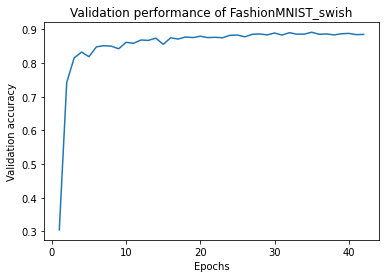

============ Test accuracy: 88.08% ============



In [21]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Not surprisingly, the model using the sigmoid activation function shows to fail and does not improve upon random performance (10 classes => 1/10 for random chance). 

All the other activation functions gain similar performance.
To have a more accurate conclusion, we would have to train the models for multiple seeds and look at the averages.
However, the "optimal" activation function also depends on many other factors (hidden sizes, number of layers, type of layers, task, dataset, optimizer, learning rate, etc.) so that a thorough grid search would not be useful in our case.
In the literature, activation functions that have shown to work well with deep networks are all types of ReLU functions we experiment with here, with small gains for specific activation functions in specific networks.

### Visualizing the activation distribution

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh?
To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:

In [22]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 

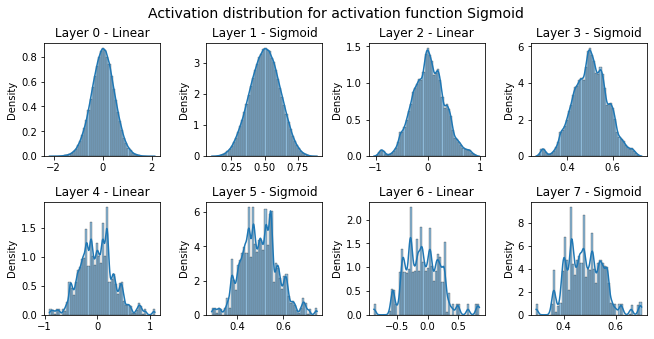

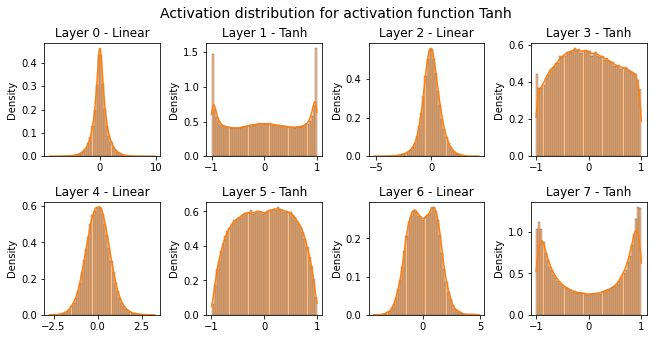

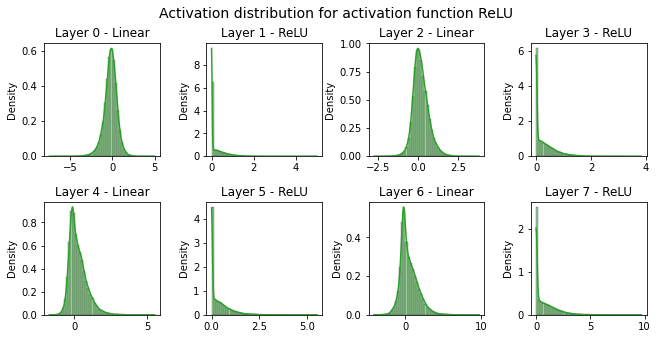

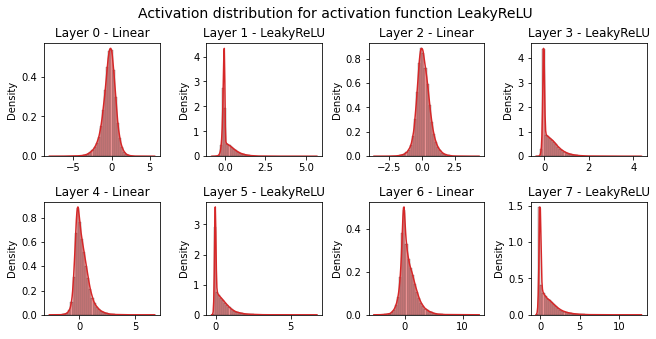

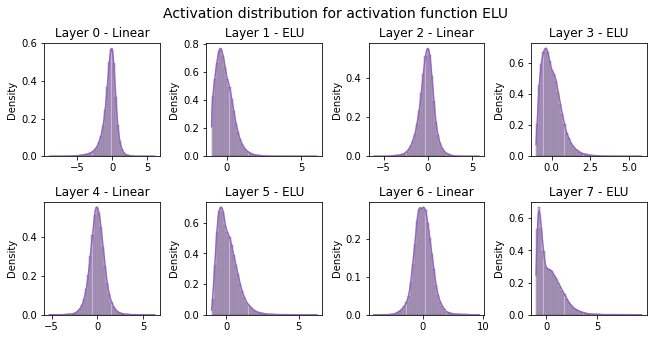

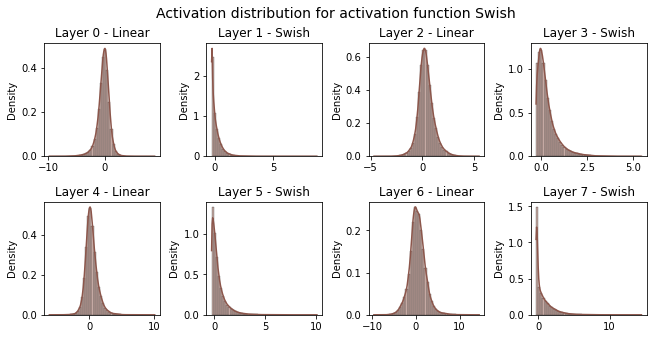

In [23]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

As the model with sigmoid activation was not able to train properly, the activations are also less informative and all gathered around 0.5 (the activation at input 0).

The tanh shows a more diverse behavior. While for the input layer we experience a larger amount of neurons to be close to -1 and 1, where the gradients are close to zero, the activations in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. The activations for the last layer are again more biased to the extreme points because the classification layer can be seen as a weighted average of those values (the gradients push the activations to those extremes).

The ReLU has a strong peak at 0, as we initially expected. The effect of having no gradients for negative values is that the network does not have a Gaussian-like distribution after the linear layers, but a longer tail towards the positive values. 
The LeakyReLU shows a very similar behavior while ELU follows again a more Gaussian-like distribution. 
The Swish activation seems to lie in between, although it is worth noting that Swish uses significantly higher values than other activation functions (up to 20).

As all activation functions show slightly different behavior although obtaining similar performance for our simple network, it becomes apparent that the selection of the "optimal" activation function really depends on many factors, and is not the same for all possible networks.

### Finding dead neurons in ReLU networks

One known drawback of the ReLU activation is the occurrence of "dead neurons", i.e. neurons with no gradient for any training input.
The issue of dead neurons is that as no gradient is provided for the layer, we cannot train the parameters of this neuron in the previous layer to obtain output values besides zero.
For dead neurons to happen, the output value of a specific neuron of the linear layer before the ReLU has to be negative for all input images.
Considering the large number of neurons we have in a neural network, it is not unlikely for this to happen. 

To get a better understanding of how much of a problem this is, and when we need to be careful, we will measure how many dead neurons different networks have. For this, we implement a function which runs the network on the whole training set and records whether a neuron is exactly 0 for all data points or not:

In [24]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

First, we can measure the number of dead neurons for an untrained network:

In [25]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


We see that only a minor amount of neurons are dead, but that they increase with the depth of the layer.
However, this is not a problem for the small number of dead neurons we have as the input to later layers is changed due to updates to the weights of previous layers. Therefore, dead neurons in later layers can potentially become "alive"/active again. 

How does this look like for a trained network (with the same initialization)?

In [26]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 2, 6]
In percentage: 0.00%, 0.00%, 0.78%, 4.69%


The number of dead neurons indeed decreased in the later layers. However, it should be noted that dead neurons are especially problematic in the input layer. As the input does not change over epochs (the training set is kept as it is), training the network cannot turn those neurons back active. Still, the input data has usually a sufficiently high standard deviation to reduce the risk of dead neurons.

Finally, we check how the number of dead neurons behaves with increasing layer depth. For instance, let's take the following 10-layer neural network:

In [27]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%


The number of dead neurons is significantly higher than before which harms the gradient flow especially in the first iterations. For instance, more than 56% of the neurons in the pre-last layer are dead which creates a considerable bottleneck.
Hence, it is advisible to use other nonlinearities like Swish for very deep networks.

## Conclusion

In this notebook, we have reviewed a set of six activation functions (sigmoid, tanh, ReLU, LeakyReLU, ELU, and Swish) in neural networks, and discussed how they influence the gradient distribution across layers. Sigmoid tends to fail deep neural networks as the highest gradient it provides is 0.25 leading to vanishing gradients in early layers. All ReLU-based activation functions have shown to perform well, and besides the original ReLU, do not have the issue of dead neurons. When implementing your own neural network, it is recommended to start with a ReLU-based network and select the specific activation function based on the properties of the network.

## Appendix: Downloading pretrained models

Suppose we have pretrained models stored in some repository. The following cell shows how to download these models.

In [28]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/particle1331/saved_models/main/tutorial3/"

# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar", 
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]

# For each file, check whether it already exists. If not, try downloading it.
for file_name in tqdm_notebook(pretrained_files):
    file_path = CHECKPOINT_PATH / file_name
    if file_path.is_file():
        print(f"{file_name: <30} already exists. Skipping download.")
    if not file_path.is_file():
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

NameError: name 'tqdm_notebook' is not defined